In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import csv

In [2]:
def station_reader(file):
    """
    Reads the station CSV file into a python dictionary, removing null and invalid data
    """
    df = pd.read_csv(file, usecols =[0,2,3], names = ['Station ID', 'latitude', 'longitude'])
    df = df.dropna(axis=0) 
    df = df[(df.latitude != 0) | (df.longitude != 0)]
    df = df.drop_duplicates(subset = 'Station ID')
    df = df.set_index('Station ID')
    
    return df

In [3]:
def temp_reader(file):
    """
    Reads the temperature CSV file into a python dataframe
    """
    df = pd.read_csv(file, usecols = [0,2,3,4], names = ['Station ID', 'Month', 'Day', 'Temperature'])
    
    return df

In [4]:
def to_radians(df):
    """
    converts a dataframe showing degree values into radians
    """
    df = (df * math.pi) /180.0
    return df

In [5]:
def haversine(lat1, lon1, lat2, lon2):
    """
    runs the haversine function
    credit to professor Rachlin who allowed us to use this function explained in his class
    """
    dlat = (lat2 - lat1) 
    dlon = (lon2 - lon1) 

    a = (pow(math.sin(dlat / 2), 2) +
         pow(math.sin(dlon / 2), 2) *
            math.cos(lat1) * math.cos(lat2));
    
    r = 6371
    c = 2 * math.asin(math.sqrt(a))
    return r * c

In [6]:
def merge(station, temps):
    """
    Merges the station and temp dataframes, so that each station ID repeats showing the temperature and date for every
        day in 1986
    """
    station_temps = stations.merge(temps, how = 'left', left_on = 'Station ID', right_on = 'Station ID')
    station_temps = station_temps.dropna()
    return station_temps

In [7]:
def date_selector(df, month, day):
    """
    filters the data based on month and date parameters, and returns the filtered data frame of only showing the exact
        date
    """
    df = df[df.Month == month]
    df = df[df.Day == day]
    return df

In [8]:
def inverse_distance_wt(station_temps, p):
    """
    Applies the inverse weight function to all of the temperatures within 100 miles of Cape Canaveral. 
        returns the temperature at CC as a float value
    """
    a = sum(station_temps.Temperature / station_temps.distances**p)
    b = sum(1 / station_temps.distances**p)
    return a / b

In [9]:
def january_plot(d):
    """
    plots the temperature at Cape Canaveral for every day in January on a bar graph
    """
    x = d.keys()
    y = d.values()
    
    plt.figure(figsize=(10,5))
    
    #Makes the lowest temperature in the list red in color
    c = ['blue' if (temp > min(y)) else 'red' for temp in y ]
    
    plt.bar(d.keys(), d.values(), color=c)
    plt.xlabel('Day in January')
    plt.ylabel('Fahrenheit'u"\u00b0")
    plt.title('Temperatures in Cape Canaveral FL in January 1986')
    
    ##Credit the below line to SackOverflow user unutbu who displayed how to change freq of x-tick markers
    #https://stackoverflow.com/questions/12608788/changing-the-tick-frequency-on-x-or-y-axis-in-matplotlib
    plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    
    plt.show()

In [10]:
def us_stations(df):
    """ Filters a dataframe to only show stations within the latitude range of 25:50 and longitude range of -125:-65
        
        Additionally finds the relative values of all filtered long and lat values, and normalizes them to fit a 
            150,100 dataframe. Finally, the function rounds the normalized values to integers
    """
    df = df[(df.latitude > 25) & (df.latitude < 50)]
    df = df[(df.longitude > -125) & (df.longitude < -65)]
    
    #find the relative values by subtracting the minimum GPS value from each point
    df['rel_lon'] = df['longitude']  + 125
    df['rel_lat'] = df['latitude'] - 25
    
    #normalize to fit the (150, 100) NP array
    df['rel_lon'] = (df['rel_lon'] * 2.5) -1
    df['rel_lat'] = (df['rel_lat'] * 4) -1
    
    #round to integers
    df['rel_lon'] = df['rel_lon'].round().astype(int)
    df['rel_lat'] = df['rel_lat'].round().astype(int)
    return df

In [11]:
def color_bucket(df):
    """This function creates a temperature bin column and inputs temperature values in bins of 10 degrees
    """
    bins = [-10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
    labels = [1,2,3,4,5,6,7,8,9,10]
    df['binned'] = pd.cut(df['Temperature'], bins,labels=labels)
    return df


In [12]:
def color_array(a):
    """this function returns 3 digit RGB values based on the temperature bin parameter provided as an int
    """
    if a == 1:
        return [127, 255, 212] #weather stations less than 0 degrees will be shown in aqua marine
    elif a ==2:
        return [0,255,255] #temperatures between 0 and 10 degrees will be shown in cyan
    elif a ==3:
        return [0,128,128] #temperatures between 10 and 20 degrees will be shown in teal
    elif a ==4:
        return [0,0,255] #temperatures between 20 and 30 degrees will be shown in blue
    elif a ==5:
        return [0,128,0] #temperatures between 30 and 40 degrees will be shown in green
    elif a==6:
        return [0,255,0] #temperatures between 40 and 50 degrees will be shown in lime 
    elif a==7:
        return [255,255,0] #temeratures between 50 and 60 degrees will be shown in yellow
    elif a==8:
        return [255,140,0] #temperatures between 60 and 70 degrees will be dark orange
    elif a==9:
        return [255,0,0] #temperatures between 70 and 80 degrees will be red
    elif a==10:
        return [220,20,60] #temperature values between 80 and 90 degrees will be crimson

In [13]:
def image_array(lst, df):
    """
    this function creates an empty 3 dimensional numpy array and inserts 3 digit RGB values at their correct position 
        based on their normalized longitude and latitude values. The function returns the 3 dimensional array
    """
    m = np.zeros([150,100,3])
    a = 0
    for i, row in df.iterrows():
        m[int(row['rel_lon']), int(row['rel_lat'])] = lst[a]
        a = a+1
    #rotate the array 90 degrees to show up correctly when plotted
    m = np.rot90(m)
    return m

In [14]:
def image_plt(data,title):
    """
    plots the 3 dimensional numpy array of temperature RGB values
    """
    plt.figure(figsize=(12,8))
    plt.title(title)
    #divide the RGB values in order to show colors correctly
    a = plt.imshow(data/255)
    plt.show()

The inverse weighted temperature on the day of the crash was 34.77746831722979


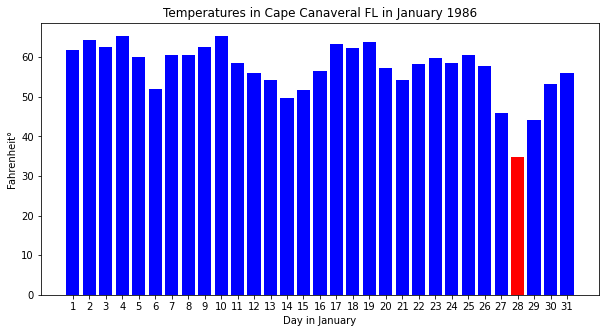

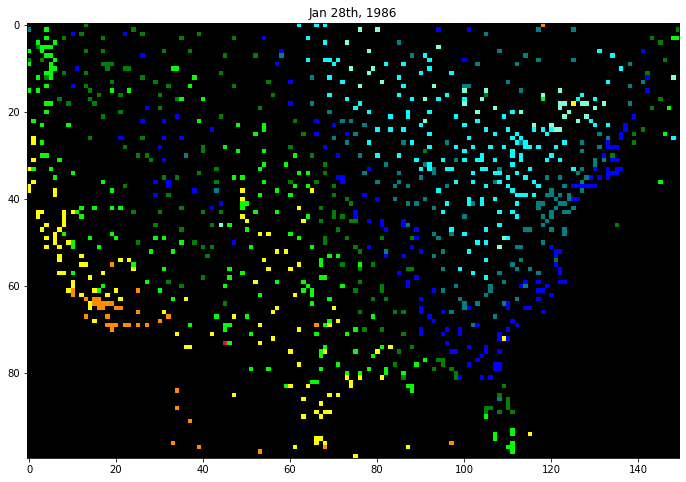

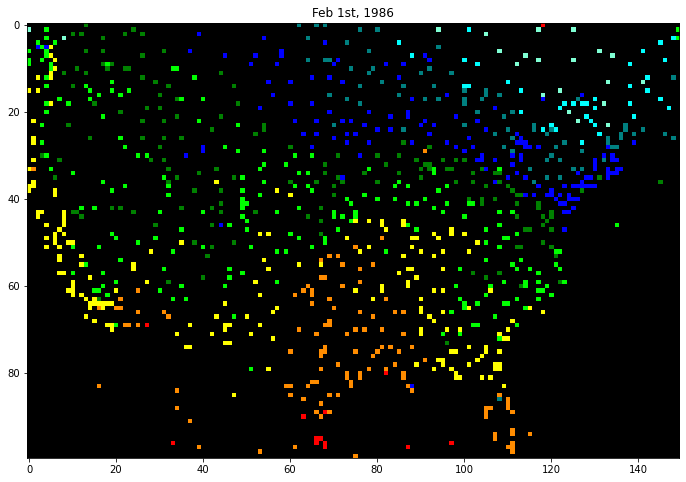

In [15]:
##PART A###
#question 1 and 2
stations = station_reader('stations.csv')
temps = temp_reader('temp_1986.csv')

#start question 3
#change the station data to show in radians
rad_stations = to_radians(stations)

#variables of the gps coordiantes at Cape Canaveral in Radians
cc_lat = 0.495618303
cc_long = -1.406834145

##Credit below to Professor Rachlin who showed our class how to vectorize a trig function
#applies the haversine distance function to find the distance of all stations from the Cape Canaveral coordinates
stations['distances'] = rad_stations.apply(lambda row : 
                                 haversine(cc_lat, cc_long, row.latitude, row.longitude), axis=1);

#merges the station and temperature data
station_temps = merge(stations, temps)

#filters only stations within 100km of Cape Canaveral
close_stations = station_temps[station_temps.distances <= 100]
#end question 3

#filters data only from January 28
date_temp = date_selector(close_stations, 1, 28)

#question 4 - prints the temperature in Cape Canaveral on January 28
cc_temp = inverse_distance_wt(date_temp, 1)
print("The inverse weighted temperature on the day of the crash was",cc_temp)

#question 5 - create the plot showing the temperatures at CC on every day in January
d = {i : inverse_distance_wt(date_selector(close_stations, 1, i), 1) for i in range(1,32)}
january_plot(d)

###PART B###

jan28 = date_selector(station_temps,1, 28)

#question 1
usstations_jan28 = us_stations(jan28)

#bin temperatures into 10 degree buckets
usstations_jan28 = color_bucket(usstations_jan28)

#get RBG values based on binned values
clrlst = []
for a in usstations_jan28["binned"]:
    clrlst.append(color_array(a))

#question 2
img_array = image_array(clrlst, usstations_jan28)

#question 3
image_plt(img_array, "Jan 28th, 1986")

#question 3 - all steps repeated to create February 1st temperature plot
feb1 = date_selector(station_temps,2, 1)
usstations_feb1 = us_stations(feb1)
usstations_feb1 = color_bucket(usstations_feb1)
clrlst = []
for a in usstations_feb1["binned"]:
    clrlst.append(color_array(a))

img_array1 = image_array(clrlst, usstations_feb1)

image_plt(img_array1, "Feb 1st, 1986")
